In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2 as cv
import os
from sklearn.utils import shuffle
import pickle
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [2]:
def take_img(ruta):
    vs =  cv.VideoCapture(0)
    key = cv.waitKey(1)
    while True:
        try:
            check, frame = vs.read()
            #print(check) #prints true as long as the webcam is running
            #print(frame) #prints matrix values of each framecd 
            cv.imshow("Capturano", frame)
            key = cv.waitKey(1)
            if key == ord('s'):
                print('Capturando imagen...')
                cv.imwrite(filename=ruta, img=frame)
                vs.release()
                img_new = cv.imread(ruta,3)
                img_new = cv.imshow("imgen tomada", img_new)
                cv.waitKey(1650)
                cv.destroyAllWindows()
                print("Processing image...")
                img_readed = cv.imread(ruta, cv.IMREAD_ANYCOLOR)
                im = cv.getRectSubPix(img_readed, (360, 360), (320, 240))
                #im = img_readed[400:400, 200:200]
                img_resized = cv.resize(im,(64,64))
                img_rgb = cv.cvtColor(img_resized, cv.COLOR_BGR2RGB)
                img_rgb = img_rgb[...,::-1].copy()
                img_final = cv.imwrite(filename=ruta, img=img_rgb)
                print("Imagen guarda!, esa en la ruta: {}".format(ruta))
                break
        except(KeyboardInterrupt):
            print("apagando camera.")
            vs.release()
            print("Camera fuera.")
            cv.destroyAllWindows()
            break

In [3]:
def prediction_model(img, predice):
    img_reshape = img.reshape([64,64,3])
    #m2 = im2.T;
    plt.imshow(img_reshape)
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    if(predice[0] == 1):
        #if(predice[0] == 1):
        response = 'Hombre'
    elif(predice[0] == 0):
        response = 'Mujer'
    else:
        response = 'Indeterminado'
    print('Lo predice como: {}'.format(response))

In [4]:
def charge_dataset(ruta):
    File = open(ruta, 'rb')
    data_x_tmp = pickle.load(File)
    data_y = pickle.load(File)
    File.close()
    del(File)
    return data_x_tmp, data_y

def convpool(X, W, b):
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return tf.nn.relu(pool_out)

def _print_img(dimx):
    print("Dimensión de la imagen {}".format(dimx.shape))
    
def get_images(test_ruta, Xt):
    img = cv.imread(test_ruta,3)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    ima = cv.resize(img,(64,64))
    Xt.append(ima)
    return Xt

def show_img(img):
    img_reshape = img.reshape([64,64,3])
    #m2 = im2.T;
    plt.imshow(img_reshape)

In [5]:
ruta = 'images/test/test19.jpg'
take_img(ruta)

Capturando imagen...
Processing image...
Imagen guarda!, esa en la ruta: images/test/test19.jpg


In [6]:
num = 9
test_ruta = 'images/test/test ('+str(num)+').jpg'
#test_ruta = ruta
Xt = get_images(test_ruta, Xt=list())
img = np.array(Xt)

Dimensión de la imagen (1, 64, 64, 3)


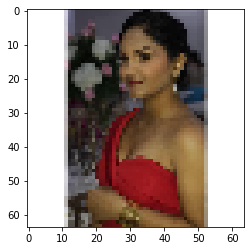

In [7]:
_print_img(img)
show_img(img)

In [8]:
img_resh = img.reshape(img.shape[0],(img.shape[1]*img.shape[2]*img.shape[3]))
print(img_resh.shape)

(1, 12288)


In [9]:
def cr_res():
    res = ([[0], [1]])
    print(res)
    return res
res= cr_res()

[[0], [1]]


In [10]:
oneHot = OneHotEncoder()
oneHot.fit(res)
res = oneHot.transform(res).toarray()

C:\Users\joseo\Anaconda3\envs\automatas\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [11]:
res

array([[1., 0.],
       [0., 1.]])

In [12]:
def create_hip():
    n_char = np.shape(img_resh)[1]         # Número de cararcteristicas
    n_class = 2
    hidden_layer_size = 300
    samples = np.shape(img_resh)[0]
    colmns = np.shape(img_resh)[1]
    #Placeholders
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [samples, 64, 64, 3])
    Y = tf.placeholder(tf.float32, [2, n_class])
    W1 = tf.get_variable("W1", [8, 8, 3, 32])
    b1 = tf.get_variable("b1", 32)
    W2 = tf.get_variable("W2",[8, 8, 32, 64])
    b2 = tf.get_variable("b2", 64)
    W3 = tf.get_variable("W3",[16*16*64, hidden_layer_size])
    b3 = tf.get_variable("b3",[hidden_layer_size])
    W4 = tf.get_variable("W4",[hidden_layer_size, n_class])
    b4 = tf.get_variable("b4",n_class)
    Z1 = convpool(X, W1, b1)
    Z2 = convpool(Z1, W2, b2)
    Z2_shape = Z2.get_shape().as_list()
    Z2r = tf.reshape(Z2, [Z2_shape[0], np.prod(Z2_shape[1:])])
    Z3 = tf.nn.relu( tf.matmul(Z2r, W3) + b3 )
    Z = tf.matmul(Z3, W4) + b4
    y_ = tf.nn.tanh(Z)
    return X, Y, y_

In [13]:
X, Y, y_ = create_hip()
predice = tf.argmax(y_, 1)

W1118 11:01:40.401982  3832 deprecation.py:506] From C:\Users\joseo\Anaconda3\envs\automatas\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, os.getcwd()+"/modeloCNN.ckpt")
    img_resh = img_resh.reshape(img_resh.shape[0], 64, 64, 3)
    predice = sess.run([predice], feed_dict={X: img_resh})

W1118 11:01:41.858387  3832 deprecation.py:323] From C:\Users\joseo\Anaconda3\envs\automatas\lib\site-packages\tensorflow\python\training\saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [15]:
np.array(predice).shape

(1, 1)

Lo predice como: Mujer


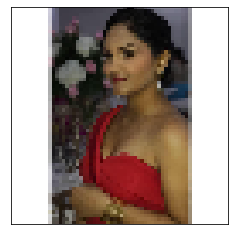

In [16]:
prediction_model(img, predice)